In [1]:
import sys
from os.path import dirname
import os
sys.path.append(dirname(os.getcwd()))

In [2]:
from autoquant.collector import Collector
from autoquant import  StocksIndex

collector = Collector.default()
stocks = collector.stocks_of_index(index=StocksIndex.HS300)
stocks

[2022-10-06 22:37:54] [78286:8643855872] [DEBUG] [autoquant.log] log.py:<module>:32 AutoQuant logs will be printed in console
login success!
logout success!


,updated_at,market,code,name
0,2022-08-01,Market.SH,600000,浦发银行
1,2022-08-01,Market.SH,600009,上海机场
2,2022-08-01,Market.SH,600010,包钢股份
3,2022-08-01,Market.SH,600011,华能国际
4,2022-08-01,Market.SH,600015,华夏银行
...,...,...,...,...
295,2022-08-01,Market.SZ,300896,爱美客
296,2022-08-01,Market.SZ,300919,中伟股份
297,2022-08-01,Market.SZ,300957,贝泰妮
298,2022-08-01,Market.SZ,300979,华利集团


In [3]:
from datetime import date

datas = list()
start_date = date(2011, 1, 4)
end_date = date(2021, 12, 31)
for i, row in stocks.iterrows():
    try:
        data = collector.daily_prices(market=row['market'], code=row['code'], start=start_date, end=end_date)
        if data.datetime[0].date() == start_date:
            datas.append(data)
    except:
        pass

print(len(datas))

login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login su

logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout s

In [4]:
from autoquant.indicator import Indicator


class RCum(Indicator):
    lines = ('RCum', )
    params = dict(period=30, fomation_period=12 * 30)
    
    def next(self):
        ps = self.data[self.p.period * -1]
        pst = self.data[(self.p.period + self.p.fomation_period) * -1]
        self.lines.RCum[0] = ps / pst - 1




In [5]:
from autoquant.strategy import Strategy

class PriceMomentum(Strategy):
    
    params = dict(period=30, holding_period=30)

    def __init__(self):

        self.rcums = dict()
        for i, d in enumerate(self.datas):
            self.rcums[i] = RCum(d)

    def next(self):
        
        # 非调仓日
        if len(self) % self.p.period != 0:
            return
        
        # 计算待买入股票
        rcums = [(i, r[0]) for i, r in self.rcums.items()]
        rcums = sorted(rcums, key=lambda x: x[1], reverse=True)
        i_top10 = list(map(lambda x: x[0], rcums[:10]))
        cash = self.broker.get_cash()
        
        # 保留或买入待买入股票，平掉其他股票
        for i, d in enumerate(self.datas):
            holding_size = self.getposition(d).size
            if i not in i_top10 and holding_size:
                self.sell(data=d, size=holding_size)
            else:
                self.buy(data=d, size=cash // 10)
                
    def log(self, msg, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print(f'{dt.isoformat()}, {msg}')
                
    def notify_trade(self, trade):
        if trade.isclosed:
            self.log(f'close {trade.getdataname()} , total_profit: {trade.pnl} , net_profit: {trade.pnlcomm}')
            
        if trade.isopen:
            self.log(f'open {trade.getdataname()} , price: {trade.price} ')
     

In [6]:
from autoquant.broker import Broker

broker = Broker.default(kick_start=100000, commission=0.01)

In [7]:
from autoquant.workflow import Workflow

w = Workflow().with_broker(broker).with_strategy(PriceMomentum).backtest(*datas)
print(w.summary())

/Users/xian/opt/anaconda3/lib/python3.9/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


2011-07-04, open SH.600000 , price: 9.79 
2011-08-15, close SH.600000 , total_profit: -7199.999999999989 , net_profit: -9085.999999999989
2011-08-15, open SH.600009 , price: 12.86 
2011-08-15, open SH.600010 , price: 6.8 
2011-08-15, open SH.600011 , price: 4.58 
2011-08-15, open SH.600015 , price: 10.02 
2011-08-15, open SH.600016 , price: 5.4 
2011-08-15, open SH.600018 , price: 3.57 
2011-08-15, open SH.600019 , price: 5.33 
2011-08-15, open SH.600028 , price: 7.19 
2011-08-15, open SH.600029 , price: 8.13 
2011-08-15, open SH.600030 , price: 11.85 
2011-08-15, open SH.600031 , price: 16.73 
2011-08-15, open SH.600036 , price: 11.66 
2011-08-15, open SH.600048 , price: 11.01 
2011-08-15, open SH.600050 , price: 4.74 
2011-08-15, open SH.600061 , price: 9.95 
2011-08-15, open SH.600085 , price: 17.03 
2011-08-15, open SH.600089 , price: 10.95 
2011-08-15, open SH.600104 , price: 16.46 
2011-08-15, open SH.600111 , price: 64.26 
2011-08-15, open SH.600115 , price: 5.55 
2011-08-15, op

2012-11-09, close SH.600000 , total_profit: 123.07000000000055 , net_profit: 64.51250000000054
2012-11-09, open SH.600009 , price: 11.12 
2012-11-09, close SH.600010 , total_profit: 158.73000000000013 , net_profit: -5.22609999999986
2012-11-09, close SH.600016 , total_profit: 267.76999999999975 , net_profit: 182.48569999999975
2012-11-09, open SH.600018 , price: 2.48 
2012-11-09, close SH.600028 , total_profit: 174.68000000000015 , net_profit: 126.56360000000015
2012-12-21, open SH.600000 , price: 9.06 
2012-12-21, close SH.600009 , total_profit: 594.150000000001 , net_profit: 432.750900000001
2012-12-21, open SH.600010 , price: 5.5 
2012-12-21, close SH.600011 , total_profit: 543.7899999999998 , net_profit: 401.4870999999998
2013-02-06, close SH.600000 , total_profit: 2999.249999999999 , net_profit: 2774.467499999999
2013-02-06, open SH.600009 , price: 13.55 
2013-02-06, close SH.600010 , total_profit: -279.4999999999998 , net_profit: -394.9549999999998
2013-02-06, open SH.600011 , pr

2014-06-25, open SH.600000 , price: 9.05 
2014-06-25, close SH.600009 , total_profit: -797.8900000000004 , net_profit: -1085.0211000000004
2014-06-25, close SH.600010 , total_profit: -338.8299999999996 , net_profit: -419.8212999999996
2014-06-25, open SH.600011 , price: 5.49 
2014-06-25, open SH.600015 , price: 8.16 
2014-06-25, open SH.600016 , price: 6.27 
2014-06-25, open SH.600018 , price: 4.43 
2014-06-25, open SH.600019 , price: 3.93 
2014-06-25, open SH.600028 , price: 5.06 
2014-06-25, open SH.600029 , price: 2.28 
2014-06-25, open SH.600030 , price: 11.37 
2014-06-25, open SH.600031 , price: 4.99 
2014-06-25, open SH.600036 , price: 10.18 
2014-06-25, open SH.600048 , price: 4.95 
2014-06-25, open SH.600050 , price: 3.2 
2014-06-25, open SH.600061 , price: 5.95 
2014-06-25, close SH.600085 , total_profit: -348.32000000000033 , net_profit: -389.39040000000034
2014-06-25, close SH.600089 , total_profit: -197.11999999999978 , net_profit: -217.95199999999977
2014-06-25, close SH.6

2020-09-29, open SH.600000 , price: 9.5 
2020-11-18, close SH.600000 , total_profit: 49.94999999999894 , net_profit: -266.899500000001
2020-11-18, open SH.600009 , price: 77.79 
2020-11-18, open SH.600010 , price: 1.19 
2020-11-18, close SH.600011 , total_profit: -877.7999999999998 , net_profit: -928.9631999999998
2020-11-18, open SH.600015 , price: 6.29 
2020-11-18, close SH.600016 , total_profit: -73.13999999999986 , net_profit: -84.81059999999985
2020-11-18, open SH.600018 , price: 4.63 
2020-11-18, open SH.600019 , price: 6.32 
2020-11-18, open SH.600028 , price: 4.1 
2020-11-18, open SH.600029 , price: 6.16 
2020-11-18, open SH.600030 , price: 29.13 
2020-11-18, open SH.600031 , price: 28.2 
2020-11-18, open SH.600036 , price: 43.6 
2020-11-18, open SH.600048 , price: 16.58 
2020-11-18, open SH.600050 , price: 4.82 
2020-11-18, open SH.600061 , price: 14.48 
2020-11-18, open SH.600085 , price: 27.17 
2020-11-18, close SH.600104 , total_profit: 275.88000000000005 , net_profit: 64.2

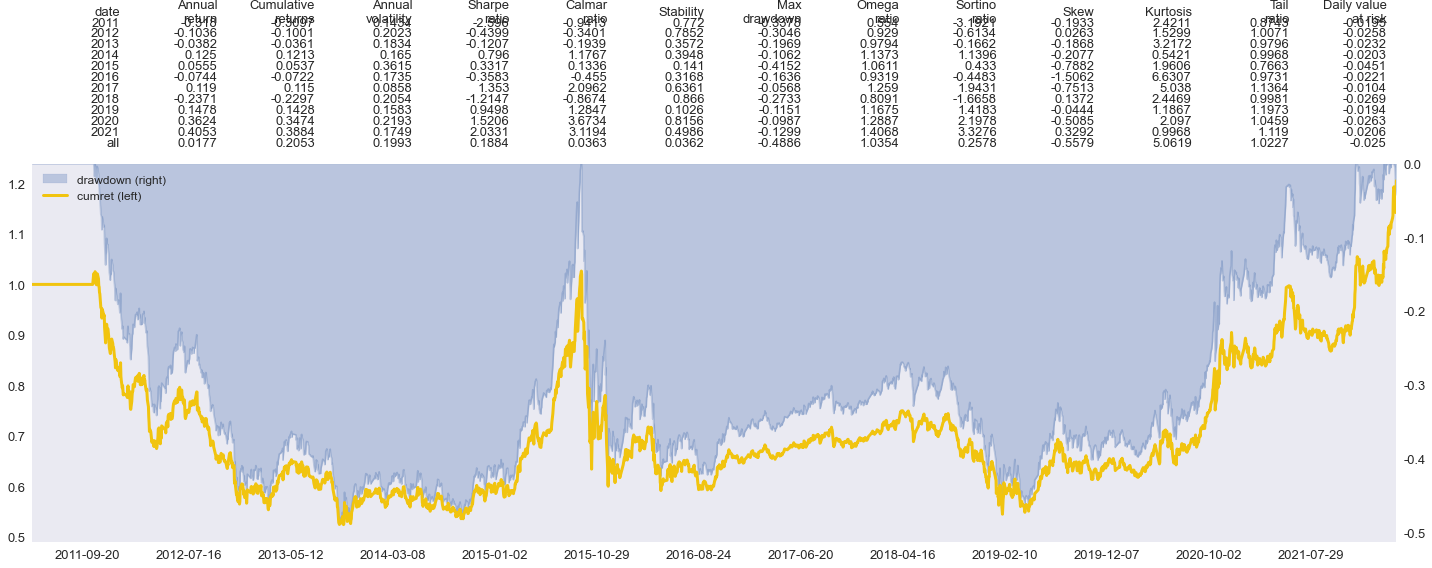

In [8]:


w.visualize()